# Microsoft data

In [24]:
from dianet import *
from torch import nn
import torch
import os
import numpy as np
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import matplotlib.pyplot as plt
import cv2

def read_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    input_data = []
    target_data = []
    
    for i, line in enumerate(lines):
        # print(i, line)
        if i % 2 == 0:  # Input data (rows 1, 3, 5, 7, ...)
            input_data.append([float(x) for x in line.strip().split()])
        else:          # Target data (rows 2, 4, 6, 8, ...)
            target_data.append([float(x) for x in line.strip().split()])

    # Convert to NumPy arrays and reshape
    input_array = np.array(input_data).reshape(-1, 64)
    target_array = np.array(target_data).reshape(-1, 64)
    
    return input_array, target_array

input_data, target_data = read_data('jpegdata/aggregated.txt')
print("input:", input_data.shape, "target:", target_data.shape)

# split data into train and test, train tset split
from sklearn.model_selection import train_test_split
train_in, test_in, train_target, test_target = train_test_split(input_data, target_data, test_size=0.1, random_state=42)
print("train input:", train_in.shape, "train target:", train_target.shape)

train_in, train_target = torch.from_numpy(train_in).float(), torch.from_numpy(train_target).float()
test_in, test_target = torch.from_numpy(test_in).float(), torch.from_numpy(test_target).float()


input: (4096, 64) target: (4096, 64)
train input: (3686, 64) train target: (3686, 64)


In [25]:
class dianet(nn.Module):
    def __init__(self):
        super(dianet, self).__init__()
        self.fc1 = nn.Linear(64, 65)
        self.fc2 = nn.Linear(65, 64)

    def make_mask(self, in_dim, out_dim):
        assert in_dim + 1 == out_dim
        mask = torch.zeros(out_dim, in_dim)
        for i in range(in_dim):
            mask[i, i] = 1
            mask[i + 1, i] = 1
        return mask
    
    def forward(self, x, dwn, up):
        self.fc1.weight.data *= self.make_mask(64, 65)
        self.fc1.weight.data = torch.clamp(self.fc1.weight.data, min=dwn, max=up)
        self.fc1.bias.data = torch.clamp(self.fc1.bias.data, min=dwn, max=up)
        x1 = torch.sigmoid(self.fc1(x)) # 65

        self.fc2.weight.data *= self.make_mask(64, 65).T
        self.fc2.weight.data = torch.clamp(self.fc2.weight.data, min=dwn, max=up)
        self.fc2.bias.data = torch.clamp(self.fc2.bias.data, min=dwn, max=up)
        x2 = self.fc2(x1) # 64
        x2_ = x2 + x
        return x2_

In [26]:
model = dianet()
# model.load_state_dict(torch.load('jpegdata/dianet.pth'))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

minloss = 100
for epoch in range(100):
    batchsize = 1
    epoch_loss = 0
    count = 0
    for i in range(0, train_in.shape[0], batchsize):
        x = train_in[i:i+batchsize]
        y = train_target[i:i+batchsize]
        optimizer.zero_grad()
        outputs = model(x,-1,1)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        count += 1
    epoch_loss /= count
    # test model
    model.eval()
    with torch.no_grad():
        test_loss = criterion(model(test_in,-1,1), test_target)
        if test_loss < minloss:
            minloss = test_loss
            torch.save(model.state_dict(), 'jpegdata/dianet-11.pth')
            print('saved at', epoch, ' with loss', minloss)

saved at 0  with loss tensor(0.0135)
saved at 1  with loss tensor(0.0035)
saved at 2  with loss tensor(0.0010)
saved at 3  with loss tensor(0.0007)
saved at 4  with loss tensor(0.0007)
saved at 5  with loss tensor(0.0007)
saved at 6  with loss tensor(0.0007)
saved at 7  with loss tensor(0.0007)
saved at 8  with loss tensor(0.0007)
saved at 9  with loss tensor(0.0007)
saved at 10  with loss tensor(0.0007)
saved at 11  with loss tensor(0.0007)
saved at 12  with loss tensor(0.0007)
saved at 13  with loss tensor(0.0007)
saved at 14  with loss tensor(0.0007)
saved at 15  with loss tensor(0.0007)
saved at 16  with loss tensor(0.0007)
saved at 17  with loss tensor(0.0007)
saved at 18  with loss tensor(0.0007)
saved at 19  with loss tensor(0.0007)
saved at 20  with loss tensor(0.0007)
saved at 21  with loss tensor(0.0007)
saved at 22  with loss tensor(0.0007)
saved at 23  with loss tensor(0.0007)
saved at 24  with loss tensor(0.0007)
saved at 25  with loss tensor(0.0007)
saved at 26  with loss

test MSE loss:  0.0006787823513150215
root-mean-square (RMS) difference 0.10759059


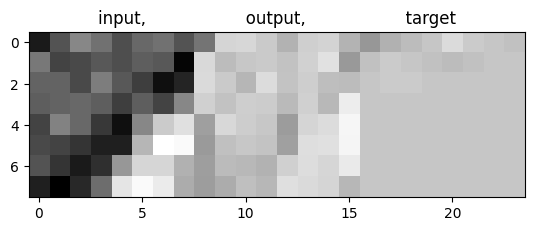

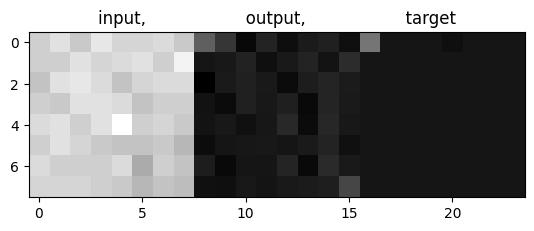

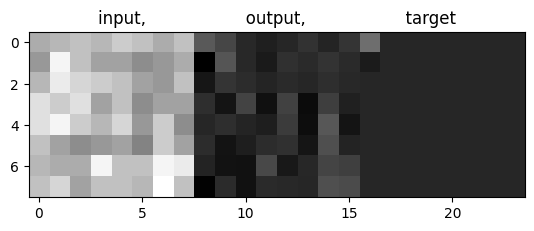

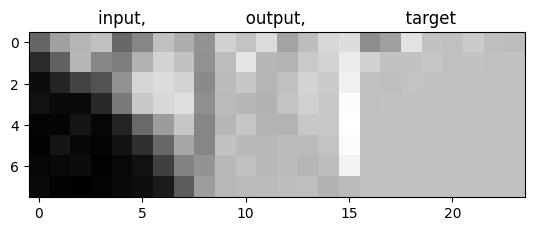

In [27]:
model = dianet()
criterion = nn.MSELoss()
model.load_state_dict(torch.load('jpegdata/dianet-11.pth'))
model.eval()
outputs = model(test_in, -1,1)
loss = criterion(outputs, test_target)
print('test MSE loss: ', loss.item())

def image_difference_error_rate(image1, image2):
    if image1.shape != image2.shape:
        raise ValueError("The two images must have the same dimensions.")

    # Calculate the squared difference between the two images
    diff = (image1 - image2) ** 2

    # Calculate the mean squared difference
    mean_squared_diff = np.mean(diff)

    # Take the square root to get the root mean square difference
    rms_diff = np.sqrt(mean_squared_diff)

    # Normalize the RMS difference to get the error rate
    error_rate = rms_diff / max(np.max(image1), np.max(image2))

    return error_rate

print('root-mean-square (RMS) difference', image_difference_error_rate(outputs.detach().numpy(), test_target.detach().numpy()))

# concat input, output, target into 1 image, horizontal, 1 row
def concat_images(imga, imgb, imgc):
    """
    Combines three color image ndarrays side-by-side to make a new
    image ndarray.
    """
    ha, wa = imga.shape[:2]
    hb, wb = imgb.shape[:2]
    hc, wc = imgc.shape[:2]
    max_height = np.max([ha, hb, hc])
    total_width = wa + wb + wc
    new_img = np.zeros(shape=(max_height, total_width))
    new_img[:ha, :wa] = imga
    new_img[:hb, wa:wa + wb] = imgb
    new_img[:hc, wa + wb:wa + wb + wc] = imgc
    return new_img

# show 10 images
for i in range(4):
    img = concat_images(test_in[i].reshape(8,8).detach().numpy(),
                         outputs[i].reshape(8,8).detach().numpy(), 
                         test_target[i].reshape(8,8).detach().numpy())
    plt.imshow(img, cmap='gray')
    plt.title('input,                   output,                   target')
    plt.show()


test MSE loss:  0.00012139668979216367
root-mean-square (RMS) difference 0.057496555


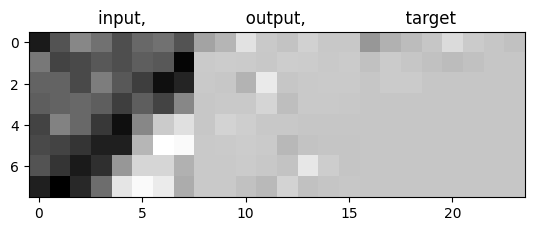

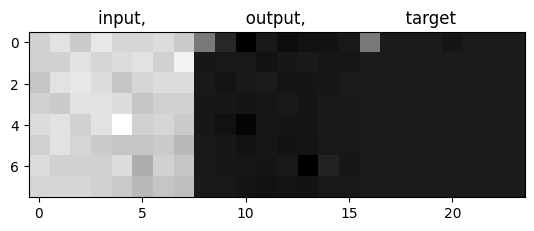

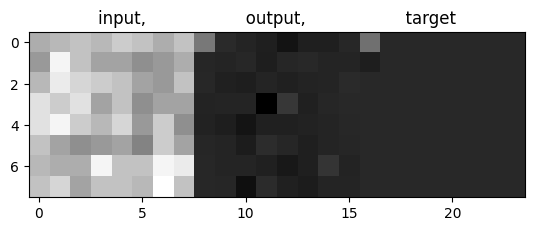

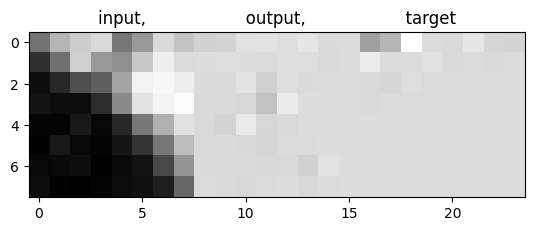

In [22]:
model = dianet()
criterion = nn.MSELoss()
model.load_state_dict(torch.load('jpegdata/dianet_nolimit.pth'))
model.eval()
outputs = model(test_in, -100,100)
loss = criterion(outputs, test_target)
print('test MSE loss: ', loss.item())

def image_difference_error_rate(image1, image2):
    if image1.shape != image2.shape:
        raise ValueError("The two images must have the same dimensions.")

    # Calculate the squared difference between the two images
    diff = (image1 - image2) ** 2
    # Calculate the mean squared difference
    mean_squared_diff = np.mean(diff)
    # Take the square root to get the root mean square difference
    rms_diff = np.sqrt(mean_squared_diff)
    # Normalize the RMS difference to get the error rate
    error_rate = rms_diff / max(np.max(image1), np.max(image2))

    return error_rate


print('root-mean-square (RMS) difference', image_difference_error_rate(outputs.detach().numpy(), test_target.detach().numpy()))

# concat input, output, target into 1 image, horizontal, 1 row
def concat_images(imga, imgb, imgc):
    """
    Combines three color image ndarrays side-by-side to make a new
    image ndarray.
    """
    ha, wa = imga.shape[:2]
    hb, wb = imgb.shape[:2]
    hc, wc = imgc.shape[:2]
    max_height = np.max([ha, hb, hc])
    total_width = wa + wb + wc
    new_img = np.zeros(shape=(max_height, total_width))
    new_img[:ha, :wa] = imga
    new_img[:hb, wa:wa + wb] = imgb
    new_img[:hc, wa + wb:wa + wb + wc] = imgc
    return new_img

# show 10 images
for i in range(4):
    img = concat_images(test_in[i].reshape(8,8).detach().numpy(),
                         outputs[i].reshape(8,8).detach().numpy(), 
                         test_target[i].reshape(8,8).detach().numpy())
    plt.imshow(img, cmap='gray')
    plt.title('input,                   output,                   target')
    plt.show()

# Clamp 0,1

In [3]:
model = dianet()
# model = baseline()
# model.load_state_dict(torch.load('jpegdata/dianet.pth'))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

minloss = 100
for epoch in range(2000):
    batchsize = 2
    epoch_loss = 0
    count = 0
    for i in range(0, train_in.shape[0], batchsize):
        x = train_in[i:i+batchsize]
        y = train_target[i:i+batchsize]
        optimizer.zero_grad()
        outputs = model(x,0,1)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        count += 1
    epoch_loss /= count
    # test model
    model.eval()
    with torch.no_grad():
        test_loss = criterion(model(test_in,0,1), test_target)
        if test_loss < minloss:
            minloss = test_loss
            torch.save(model.state_dict(), 'jpegdata/dianet01.pth')
            print('saved at', epoch, ' with loss', minloss)

saved at 0  with loss tensor(0.0387)
saved at 1  with loss tensor(0.0379)
saved at 2  with loss tensor(0.0377)
saved at 3  with loss tensor(0.0375)
saved at 4  with loss tensor(0.0374)
saved at 5  with loss tensor(0.0374)
saved at 6  with loss tensor(0.0374)
saved at 7  with loss tensor(0.0373)
saved at 8  with loss tensor(0.0373)
saved at 9  with loss tensor(0.0373)
saved at 10  with loss tensor(0.0373)
saved at 11  with loss tensor(0.0373)
saved at 12  with loss tensor(0.0373)
saved at 13  with loss tensor(0.0373)
saved at 14  with loss tensor(0.0373)
saved at 15  with loss tensor(0.0373)
saved at 16  with loss tensor(0.0373)
saved at 17  with loss tensor(0.0373)
saved at 18  with loss tensor(0.0373)
saved at 19  with loss tensor(0.0373)
saved at 20  with loss tensor(0.0373)
saved at 21  with loss tensor(0.0373)
saved at 22  with loss tensor(0.0373)
saved at 23  with loss tensor(0.0373)
saved at 24  with loss tensor(0.0373)
saved at 25  with loss tensor(0.0373)
saved at 26  with loss

test MSE loss:  0.03727294132113457
Mean relative error 0.35132498


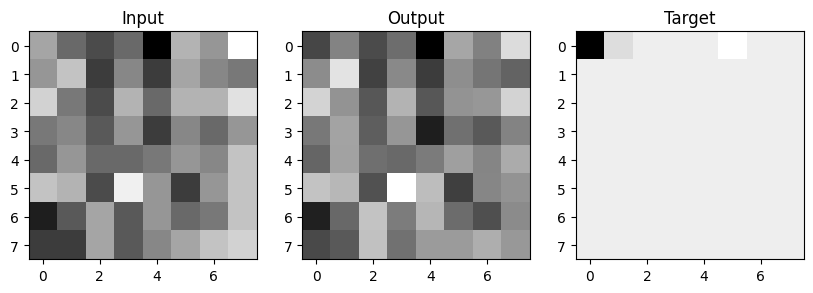

In [4]:
model = dianet() # test loss:  0.00010453681170474738, Mean relative error 0.42858585351850925
criterion = nn.MSELoss()
model.load_state_dict(torch.load('jpegdata/dianet01.pth'))
# model.load_state_dict(torch.load('jpegdata/baseline.pth'))
model.eval()
outputs = model(test_in, 0,1)
loss = criterion(outputs, test_target)
print('test MSE loss: ', loss.item())

import numpy as np

def image_difference_error_rate(image1, image2):
    if image1.shape != image2.shape:
        raise ValueError("The two images must have the same dimensions.")

    # Calculate the absolute difference between the two images
    diff = np.abs(image1 - image2)

    # Calculate the mean difference error
    mean_diff_error = np.mean(diff)

    # Normalize the mean difference error to get the error rate
    error_rate = mean_diff_error / max(np.max(image1), np.max(image2))

    return error_rate

print('Mean relative error', image_difference_error_rate(outputs.detach().numpy(), test_target.detach().numpy()))

# plot
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(test_in[0].reshape(8, 8), cmap='gray')
plt.title('Input')
plt.subplot(1, 3, 2)
plt.imshow(outputs[0].detach().numpy().reshape(8, 8), cmap='gray')
plt.title('Output')
plt.subplot(1, 3, 3)
plt.imshow(test_target[0].numpy().reshape(8, 8), cmap='gray')
plt.title('Target')
plt.show()
